In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, OPTICS


def plot_tokens_history(data, title, columns):
    plt.figure(figsize=(15, 8))
    plt.title(title)

    if columns is not None:
        plt.plot(data[columns].values)
    else:
        plt.plot(data.values, color='b', alpha=0.5)

    step = len(data.index)//6
    ticks = np.arange(0, len(data.index))[::step]
    axis_labels = data.index[::step]

    plt.xticks(ticks=ticks, labels=axis_labels)
    plt.show()


def plot_scatter_2d(data):
    plt.figure(figsize=(15, 8))
    plt.title("t-SNE visualization")
    plt.scatter(data[:, 0], data[:, 1])
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()


def plot_components(data):
    plt.figure(figsize=(15, 8))
    plt.title("Showing first 2 components")
    plt.scatter(data[:, 0], data[:, 1])
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()


def plot_pca_variance(pca, var_th):
    plt.figure(figsize=(15, 8))

    xi = np.arange(0, len(pca.explained_variance_ratio_))
    y = np.cumsum(pca.explained_variance_ratio_)

    plt.ylim(0.0, 1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='b')

    plt.xlabel('Number of Components')
    plt.xticks(np.arange(0, len(pca.explained_variance_ratio_)))
    plt.ylabel('Cumulative variance (%)')
    plt.title('The number of components needed to explain variance')

    plt.axhline(y=var_th, color='r', linestyle='-')
    plt.text(0.5, 0.85, f'{int(var_th * 100)}% cut-off threshold', color='red', fontsize=16)

    plt.show()


def dim_reduction_pca(df, var_th, show_variance):
    if show_variance:
        plot_pca_variance(pca=PCA().fit(df), var_th=var_th)

    pca = PCA(n_components=var_th).fit_transform(df)

    return pca


def train_unsupervised_algo(data, algo_name, min_samples):
    algo = None
    if algo_name == "OPTICS":
        algo = OPTICS(min_samples=min_samples).fit(data)
    if algo_name == "DBSCAN":
        algo = DBSCAN(min_samples=min_samples).fit(data)
    return algo


def compare_clusters(data, results, n_cols):
    n_rows = int(np.ceil(len(results.keys())/n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, sharey=True, sharex=True, figsize=(16, 8*n_rows))

    counter = 0
    title_names = [x for x in results.keys()]

    for i in range(0, n_rows):
        for j in range(0, n_cols):
            title = title_names[counter]
            mask = results[title] != -1

            axs[i, j].scatter(data[:, 0][~mask], data[:, 1][~mask], color='gray', alpha=0.3, s=30)
            axs[i, j].scatter(data[:, 0][mask], data[:, 1][mask], c=results[title][mask]+1, alpha=0.5, s=50, cmap="rainbow")

            axs[i, j].set_title(title_names[counter])
            counter += 1
            if counter >= len(title_names):
                break

    plt.show()


def clustering(data, grid):

    tsne_data = TSNE(n_components=2, init='random', perplexity=3).fit_transform(data)

    results = {}

    for algo in grid.keys():
        for min_samples in grid[algo]["min_samples"]:
            trained_algo = train_unsupervised_algo(data, algo_name=algo, min_samples=min_samples)
            results[f"{algo}: min_s = {min_samples}"] = trained_algo.labels_

    compare_clusters(data=tsne_data, results=results, n_cols=2)

    return results, tsne_data


def plot_group_counts(results, group):
    labels = results[group]
    h, val = np.unique(labels, return_counts=True)

    plt.figure(figsize=(15,5))
    plt.title(f"{group}:\nNumber of tokens per group")
    plt.bar(h, val)
    plt.xticks(list(range(-1, np.max(labels)+1)))
    plt.show()

In [23]:
df = pd.read_csv("~/IdeaProjects/SignatureWorkReinforcementLearning/data/raw//ClosePriceData_2022-10-01_to_2022-08-21.csv", index_col=0)
df.drop(columns=["TUSD", "BUSD"], inplace=True)

df.sort_index(inplace=True)

df_change = df/df.iloc[0]-1
df_daily_roi = df.pct_change().dropna()

print("df shape:", df.shape)
df.head()

df shape: (1000, 119)


,AAVE,ADA,ADX,AION,ALGO,AMP,ANC,ANT,ARDR,ATM,...,XLM,XMR,XRP,XTZ,XVG,XZC,ZEC,ZEN,ZIL,ZRX
2022-08-21 03:00:00,82.6,0.4498,0.1597,0.04307,0.2992,0.00717,0.08560,1.608,0.1080,5.12,...,0.1083,151.1,0.3368,1.567,0.00326,3.446,63.6,15.93,0.03720,0.3029
2022-08-21 04:00:00,82.4,0.4494,0.1597,0.04285,0.2989,0.00717,0.08507,1.608,0.1081,5.34,...,0.1083,151.2,0.3371,1.566,0.00326,3.470,63.6,15.94,0.03711,0.3041
2022-08-21 05:00:00,82.8,0.4518,0.1598,0.04325,0.2999,0.00718,0.08558,1.620,0.1081,5.42,...,0.1088,151.8,0.3389,1.578,0.00326,3.485,63.9,15.99,0.03720,0.3045
2022-08-21 06:00:00,82.0,0.4484,0.1604,0.04261,0.2983,0.00722,0.08499,1.609,0.1080,5.32,...,0.1080,151.1,0.3390,1.555,0.00320,3.486,63.4,15.84,0.03692,0.3015
2022-08-21 07:00:00,84.1,0.4579,0.1614,0.04384,0.3027,0.00722,0.08620,1.646,0.1087,5.37,...,0.1103,152.1,0.3437,1.594,0.00325,3.477,64.5,16.36,0.03761,0.3077


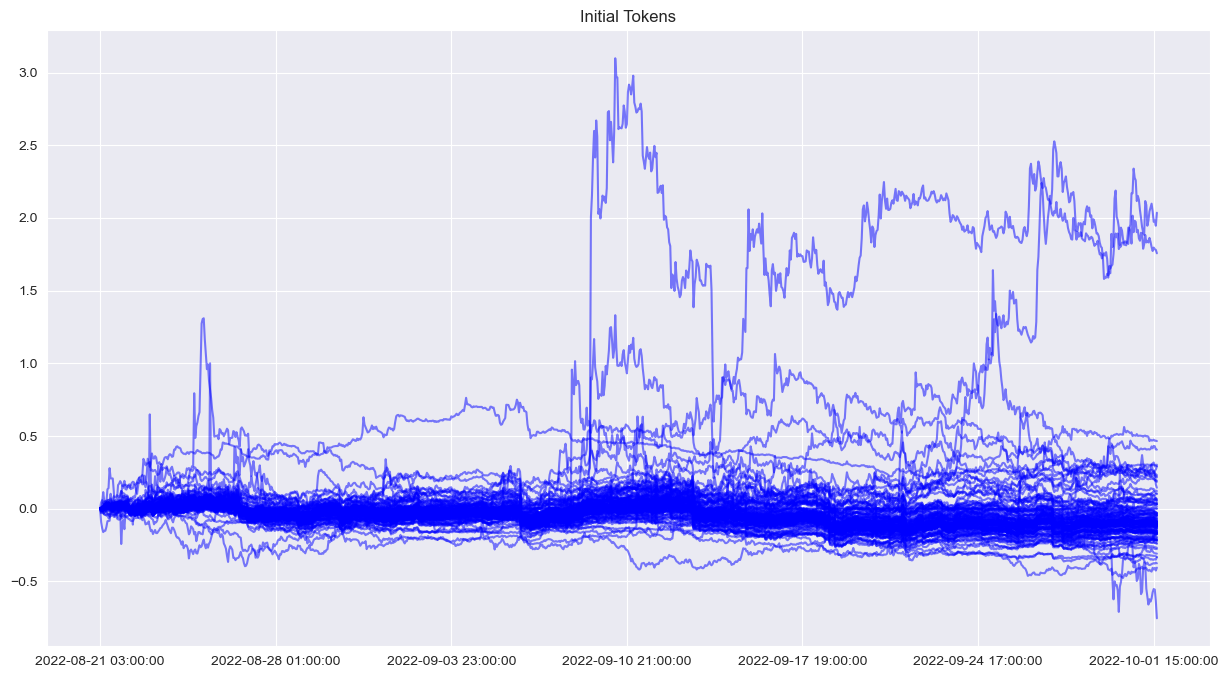

In [24]:
plot_tokens_history(data=df_change, title="Initial Tokens", columns=None)

In [25]:
data = df_daily_roi.T.values.astype(np.float64)

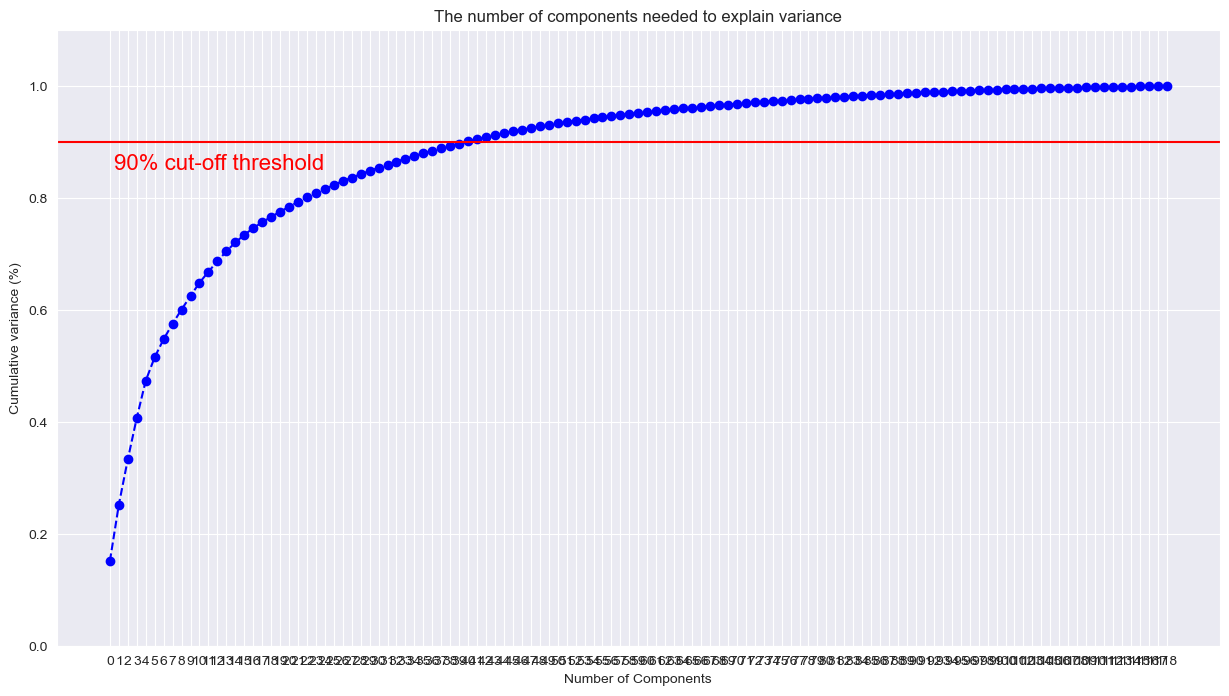

In [27]:
df_red = np.asanyarray(dim_reduction_pca(df=data, var_th=0.90, show_variance=True), dtype=np.float64)

In [37]:
search_grid = {
    "OPTICS": {"min_samples": [2, 3, 4, 5, 7, 10]},
    "DBSCAN": {"min_samples": [2, 3, 4, 5, 7, 10]}
}
search_grid

{'OPTICS': {'min_samples': [2, 3, 4, 5, 7, 10]},
 'DBSCAN': {'min_samples': [2, 3, 4, 5, 7, 10]}}

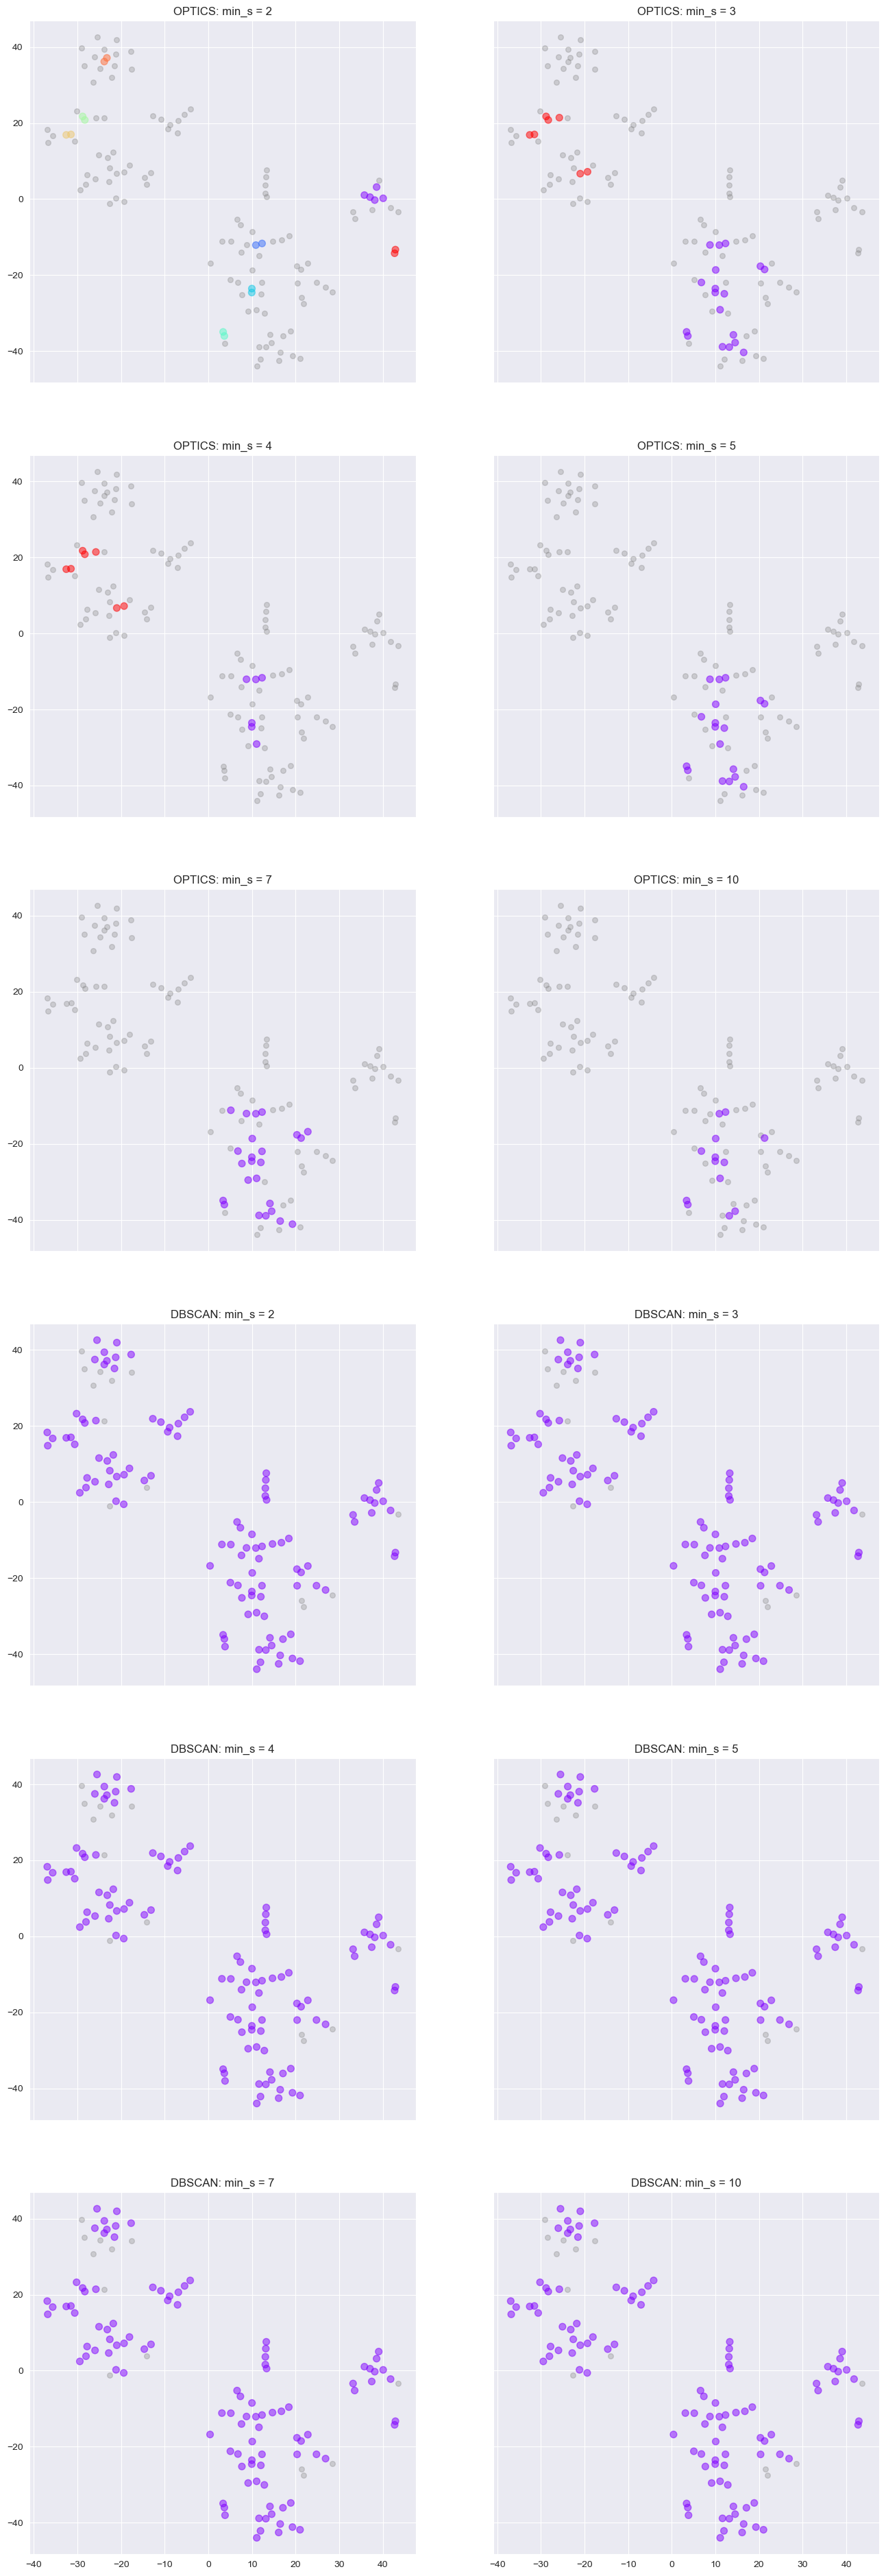

In [38]:
results, tsne_data = clustering(data=df_red, grid=search_grid)
plt.show()

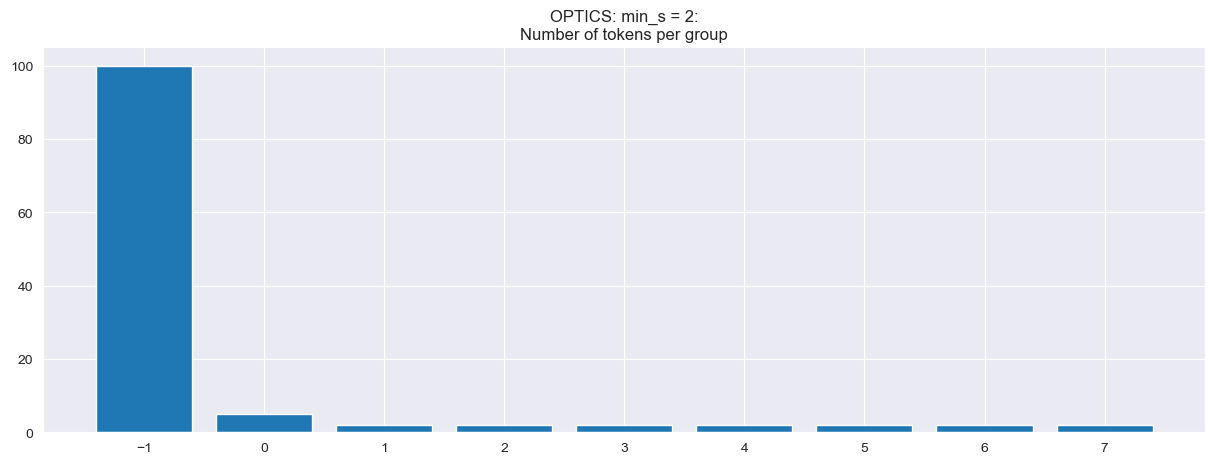

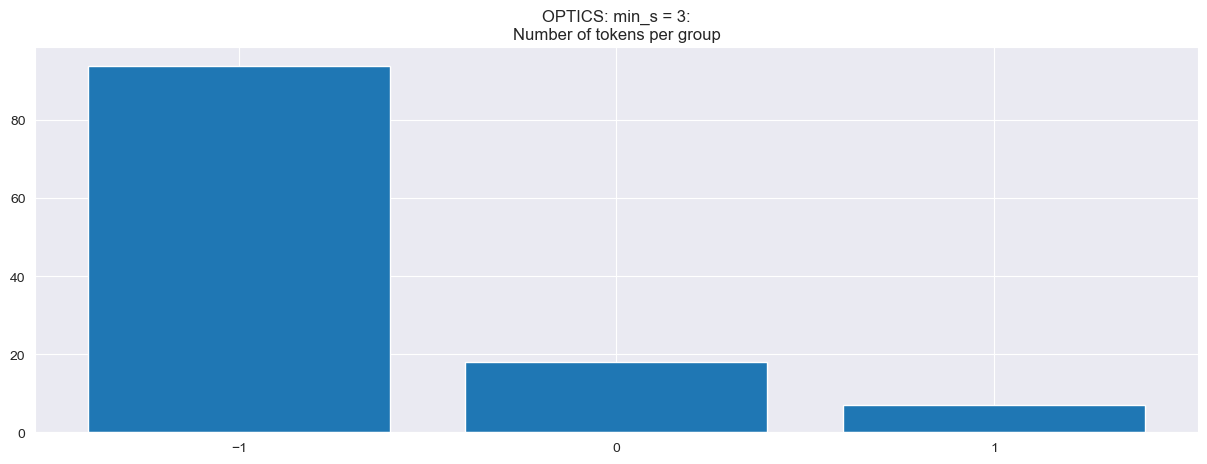

In [39]:
plot_group_counts(results, "OPTICS: min_s = 2")
plot_group_counts(results, "OPTICS: min_s = 3")

In [31]:
tokens_op2 = df.columns[results["OPTICS: min_s = 2"] != -1]
tokens_op3 = df.columns[results["OPTICS: min_s = 3"] != -1]

try:
    tokens_op2.drop("TUSD", inplace=True)
except:
    print("op2 TUSD not in options")
try:
    tokens_op2.drop("BUSD", inplace=True)
except:
    print("op2 BUSD not in options")
    
    
try:
    tokens_op3.drop("TUSD", inplace=True)
except:
    print("op3 TUSD not in options")
try:
    tokens_op3.drop("BUSD", inplace=True)
except:
    print("op3 BUSD not in options")

op2 TUSD not in options
op2 BUSD not in options
op3 TUSD not in options
op3 BUSD not in options


In [32]:
print("Optics MIN2 portfolio len:", len(tokens_op2))
print(tokens_op2)

Optics MIN2 portfolio len: 19
Index(['AAVE', 'AVAX', 'BAT', 'BNB', 'BTC', 'BTG', 'CAKE', 'ETC', 'FTT', 'FUN',
       'MANA', 'MATIC', 'NEO', 'ONT', 'QTUM', 'RUNE', 'SOL', 'TRX', 'VET'],
      dtype='object')


In [34]:
print("Optics MIN2 portfolio len:", len(tokens_op3))
print(tokens_op3)

Optics MIN2 portfolio len: 25
Index(['BAT', 'BNB', 'BTC', 'CAKE', 'DASH', 'ENJ', 'FTT', 'ICX', 'IOST',
       'IOTX', 'LRC', 'MANA', 'NEO', 'OMG', 'ONT', 'QTUM', 'SC', 'UTK', 'VET',
       'XMR', 'XTZ', 'ZEC', 'ZEN', 'ZIL', 'ZRX'],
      dtype='object')


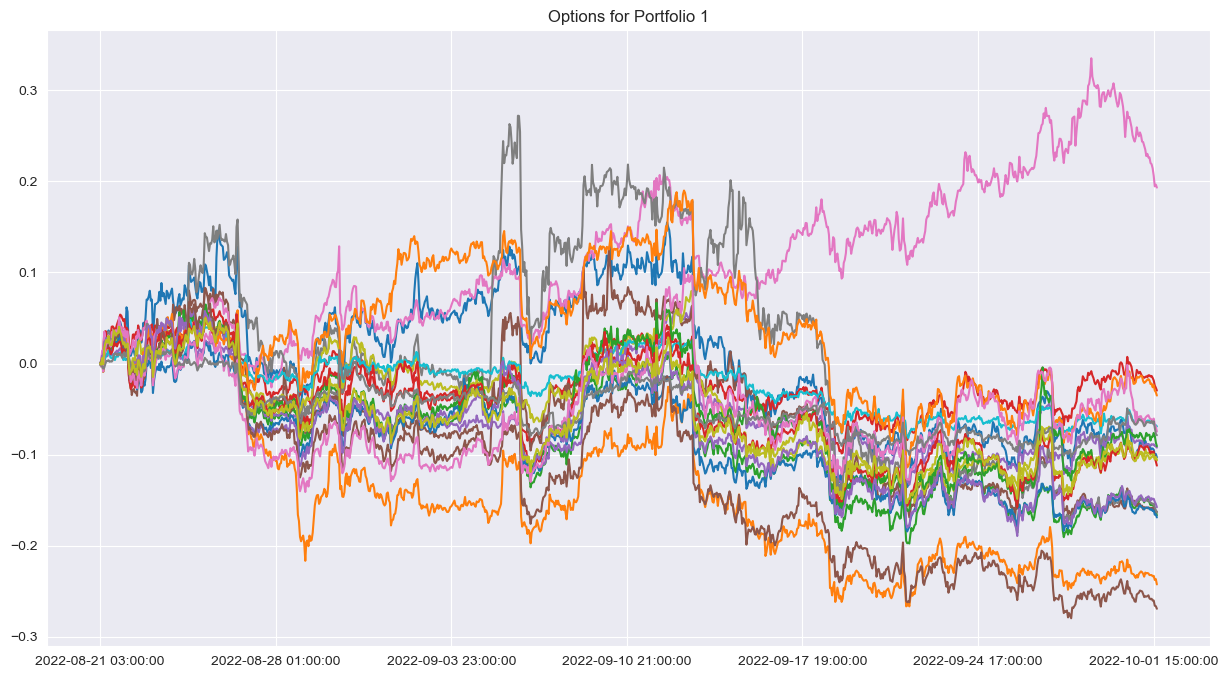

In [35]:
plot_tokens_history(data=df_change, title="Options for Portfolio 1", columns=tokens_op2)

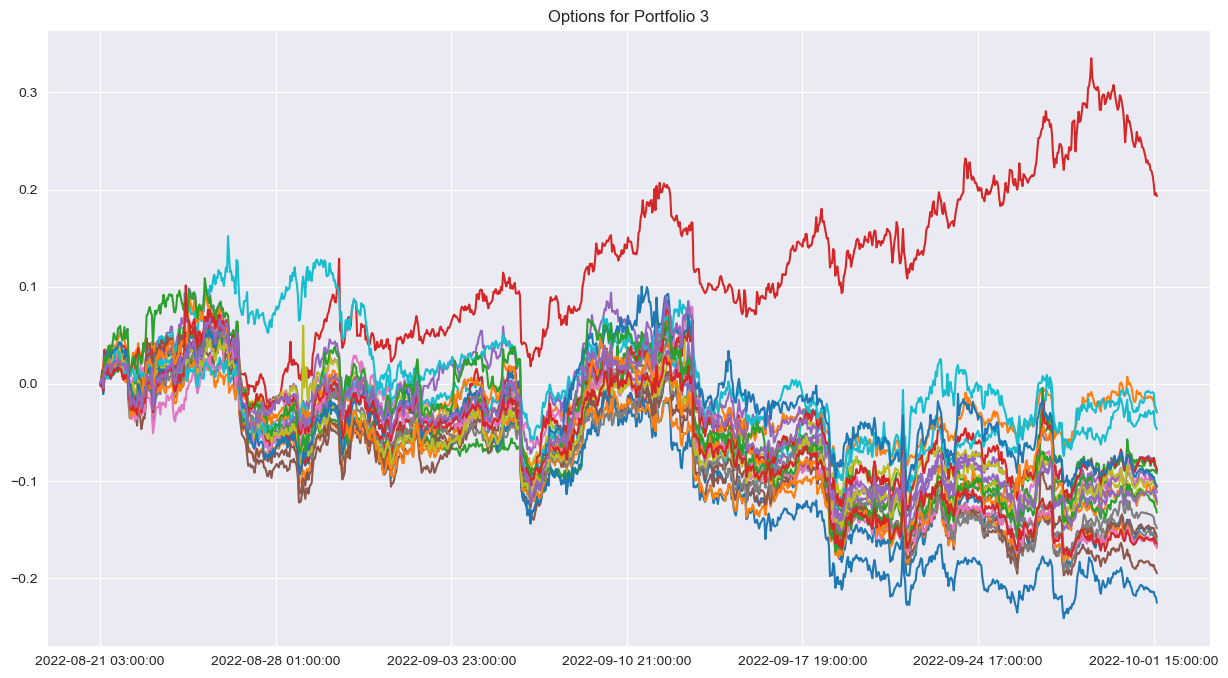

In [36]:
plot_tokens_history(data=df_change, title="Options for Portfolio 3", columns=tokens_op3)

In [31]:
portfolio_options = {
    "Portfolio 1": tokens_op2.tolist(),
    "Portfolio 2": tokens_op3.tolist()
}

In [33]:
import json

with open("portfolios/portfolios.json", "w") as outfile:
    json.dump(portfolio_options, outfile)

In [45]:
df.iloc[-9:]

,AAVE,ADA,ADX,AION,ALGO,AMP,ANC,ANT,ARDR,ATM,...,XLM,XMR,XRP,XTZ,XVG,XZC,ZEC,ZEN,ZIL,ZRX
2022-10-01 10:00:00,75.3,0.4331,0.1707,0.03903,0.3596,0.00507,0.09029,1.690,0.0964,4.68,...,0.1196,150.0,0.4747,1.427,0.00327,4.299,57.0,14.09,0.03123,0.2693
2022-10-01 11:00:00,75.2,0.4326,0.1707,0.03896,0.3616,0.00503,0.09008,1.683,0.0961,4.66,...,0.1192,149.8,0.4737,1.423,0.00326,4.280,56.9,14.04,0.03123,0.2692
2022-10-01 12:00:00,74.8,0.4311,0.1700,0.03893,0.3601,0.00505,0.09010,1.679,0.0956,4.66,...,0.1192,149.7,0.4749,1.419,0.00326,4.200,56.6,14.02,0.03122,0.2684
2022-10-01 13:00:00,74.9,0.4313,0.1712,0.03897,0.3616,0.00515,0.09045,1.681,0.0960,4.66,...,0.1199,149.7,0.4810,1.421,0.00327,4.262,56.5,14.03,0.03126,0.2689
2022-10-01 14:00:00,74.9,0.4314,0.1709,0.03897,0.3600,0.00506,0.09051,1.677,0.0956,4.65,...,0.1201,149.8,0.4767,1.416,0.00329,4.315,56.6,13.99,0.03123,0.2692
2022-10-01 15:00:00,74.8,0.4317,0.1705,0.03864,0.3616,0.00501,0.09080,1.678,0.0959,4.66,...,0.1215,149.7,0.4821,1.417,0.00328,4.289,56.9,14.00,0.03132,0.2700
2022-10-01 16:00:00,74.3,0.4297,0.1697,0.03866,0.3583,0.00496,0.09050,1.667,0.0953,4.62,...,0.1204,147.8,0.4814,1.408,0.00327,4.348,56.4,13.92,0.03112,0.2679
2022-10-01 17:00:00,74.4,0.4300,0.1708,0.03852,0.3555,0.00496,0.09062,1.663,0.0955,4.63,...,0.1199,147.3,0.4741,1.405,0.00327,4.373,56.1,13.89,0.03112,0.2680
2022-10-01 18:00:00,74.1,0.4289,0.1705,0.03852,0.3545,0.00495,0.09039,1.658,0.0954,4.62,...,0.1197,146.7,0.4736,1.401,0.00326,4.446,55.7,13.82,0.03109,0.2661
